# Рекомендательная система с использованием collab learner от fast.ai

Потренируемся работать с библиотекой грубокого обучения fast.ai. Перед запуском ноутбука рекомендуется подключить gpu для увеличения скорости обучения.

Основной ноутбук с EDA и LightFM: https://www.kaggle.com/fedorazarov/project-20-group-1-fa

Подготовка данных

In [1]:
import numpy as np
import pandas as pd

from fastai.tabular import *
from fastai.collab import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Загружаем датасеты
data_reduced = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
data_reduced = data_reduced[['userid','itemid','rating']]
data_reduced.columns = ['user_id','item_id','rating']
# Удалим дубликаты из тренировочного датасета
data_reduced.drop_duplicates(inplace = True)

test_data = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
test_data = test_data[['userid', 'itemid']]
test_data.columns = ['user_id','item_id']

submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')



/kaggle/input/recommendationsv4/train.csv
/kaggle/input/recommendationsv4/test.csv
/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json
/kaggle/input/recommendationsv4/sample_submission.csv


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
data_collab = CollabDataBunch.from_df(
    data_reduced,
    seed=42,
    user_name='user_id',
    item_name='item_id',
    rating_name='rating',
    )
data_collab.show_batch()

user_id,item_id,target
30417,39281,1.0
70600,8217,1.0
56076,22677,1.0
14065,5568,1.0
74725,4278,1.0


In [3]:
learn = collab_learner(data_collab, n_factors=50, y_range=(0, 1), wd=1e-2)

Подберем learning rate

In [4]:
learn.lr_find()

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


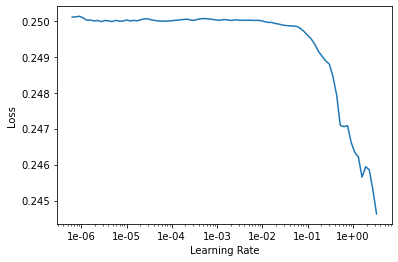

In [5]:
learn.recorder.plot()

Обучим модель

In [6]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.149332,0.151160,01:33
1,0.115654,0.126323,01:33
2,0.081994,0.126440,01:33
3,0.048011,0.128336,01:34
4,0.030411,0.128912,01:33


Сохраним модель

In [7]:
learn.save("trained_model", return_path=True)

PosixPath('models/trained_model.pth')

Укажем тестовый датасет

In [8]:
data_collab = CollabDataBunch.from_df(data_reduced, test=test_data, seed=42, valid_pct=0.2, user_name='user_id', item_name='item_id', rating_name='rating')
learn = collab_learner(data_collab, n_factors=50, y_range=(0, 1), wd=1e-2)

Загрузим ранее сохраненную модель

In [9]:
learn_loaded = learn.load(Path('trained_model'))

Получим предсказания

In [10]:
preds, y = learn_loaded.get_preds(DatasetType.Test)

In [11]:
submission['rating']= preds
submission.to_csv('submission_fastai.csv', index=False)

In [12]:
submission['rating'].mean()

0.8381931185722351

В результате получили результат 0.73 на лидерборде, что близко к базовому решению.